# Создал этот ноутбук для проверки простеньких сеток на синтетических датасетах / кусках датасетов

- Векторы V все почти что коллинеарны, когда их много - стоит уже посмотреть на $p_i$ и $r_{cut_{i}}$

- надо сделать нормализацию X и таргетов, причем для таргетов реализовать обратную функцию

In [268]:
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np

import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import torch.optim as optim
from torch.optim import lr_scheduler
from torchmetrics import MeanAbsolutePercentageError

import seaborn as sns
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})

from utility_funcs import *

In [269]:
MODE

'movements'

In [270]:
path = './dataset_objects/' + MODE + '/2_dataset_K_3.pt'

In [271]:
class CustomNormalizer:
    '''
    Класс, нормализующий векторы
    '''
    def __init__(self):
        self.mu = 0.
        self.std = 1.0
        self.normalizer = Normalizer()

    def get_mu_and_std(self, data):
        pass

    def normalize(self, data):
        '''
        
        '''
        pass

    def inverse_normalize(self, vec):
        pass

In [272]:
class CFG:
    '''

    All hyperparameters are here

    '''

    N = int(path.split("/")[-1].split('_')[0])     # число атомов
    K = int(path.split("/")[-1].split('_')[-1].split('.')[0])     # можно называть это разрешением...чем число больше, тем больше размеры матрицы для атомов, фактически это число элементов в наборах p и r_cut

    L = 2 * N ** (1 / 3) # размер одной клетки при моделировании

    r_cut = np.random.uniform(low=5, high=10, size=K).copy()
    p = np.random.uniform(low=1, high=3, size=K).copy()
    N_neig= N - 1 if N != 2 else 1

    # train_bs = 8
    # val_bs = 16
    batch_size = 128

    # device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    device="cpu"

    f_threshold = 5    # Если сила по какой-то координате превышает это значение, то строчка исключается, совсем маленьких по модулю сил быть не должно, если что при генерации просто r_cut поменьше надо делать
    coord_threshold = L     # Если вдруг очень большие расстояния, то надо выкидывать
    f_min_threshold = 0.05
    #
    output_size = K     # Размерность аутпута модели

In [273]:
def make_predictions_and_get_quality(model, X_matrices=None, Y_target=None, figsize=(30, 20), fontsize=20, criterion=nn.MSELoss(), data=None, same_axis=False, show_3D_quality=False):
    '''

    Строит предсказанную и тагрет зависимости

    Можно подавать либо отлельно X_matrices, Y_target либо подать датасет из тьюплов: (X, f_k_dim, f_3d, A_pinv)

    Будет подаваться 3 итерируемых объекта: набор(батч или кусок датасета) из "матриц", предсказания, таргеты

    returns: Y_pred, Y_target    
    '''

    if data:
        X_matrices, Y_target, pinv_As, Y_target_3D = list(map(lambda x: torch.stack(x), list(zip(*data))))
        
    Y_pred = model(X_matrices)
    metric = criterion(Y_pred, Y_target)
    names = ['predicted', 'target']
    Ys = [Y_pred, Y_target]
    metric = criterion(Y_pred, Y_target)

    maper = MeanAbsolutePercentageError()
    mape = maper(Y_pred, Y_target)

    if show_3D_quality:
        outputs_3D = torch.bmm(pinv_As, torch.unsqueeze(Y_pred.to(torch.float), 2)).to(CFG.device)    # используются для вычисления MSE метрики уже на 3D векторах силы
        outputs_3D = torch.squeeze(outputs_3D, -1)
        metric_3d = criterion(outputs_3D, Y_target_3D)
        mape_3d = maper(outputs_3D, Y_target_3D)
    
    print(
        pinv_As[3] @ Y_target[3], Y_target_3D[3]
    )

    if not show_3D_quality:
        print(f'MSE: {metric:.5f}, mape: {mape:.4f} %')
    else:
        print(f'MSE: {metric:.5f}, mape: {mape:.4f} %, MSE_for_3D_after_pinv_A: {metric_3d:.5f}, mape_3d: {mape_3d:.4f} %')

    return Ys

In [274]:
def fit_epoch(model, train_loader, criterion, optimizer, scheduler, scaler, show_3D_quality):
    '''

    Функция обучения по всем батчам 1 раз (1 эпоха)

    scaler: gradient scaler from torch.amp, попозже добавлю обучение с ним

    В данной версии: (X, f_k_dim)

    Лосс выводится для k-мерного предсказания, а mse считается по 3D вариантам, однако при K=1 3d и 1d MSE совпадают

    '''
    model.train()

    running_loss = 0.0
    running_MSE = 0
    processed_size = 0

    for inputs, labels, pinv_As, labels_3D in train_loader:
        optimizer.zero_grad()

        inputs = inputs.to(CFG.device)
        labels = labels.to(CFG.device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        if scheduler:
            scheduler.step()

        if show_3D_quality:
            # print(pinv_As.size(), torch.unsqueeze(outputs.to(torch.float), 2).size())
            outputs_3D = torch.bmm(pinv_As, torch.unsqueeze(outputs.to(torch.float), 2)).to(CFG.device)    # используются для вычисления MSE метрики уже на 3D векторах силы
            outputs_3D = torch.squeeze(outputs_3D, -1)
            running_MSE += F.mse_loss(input=outputs_3D, target=labels_3D, reduction='sum').item()

        running_loss += loss.item() * inputs.size(0)    # при очень большом размере батча последние два батча будут например размера 128 вместо 256, поэтому просто умножать на батч сайз неправильно, могут быть другого размера
        processed_size += inputs.size(0)

    # print(labels)
    train_loss = running_loss / processed_size
    if show_3D_quality:
        train_MSE = running_MSE / processed_size
        return train_loss, train_MSE
    
    return train_loss

In [275]:
def eval_epoch(model, val_loader, criterion, show_3D_quality):
    '''

    Одна эпоха по val выборке

    '''

    model.eval()
    
    running_loss = 0.0
    running_MSE = 0
    processed_size = 0

    for inputs, labels, pinv_As, labels_3D in val_loader:

        inputs = inputs.to(CFG.device)
        labels = labels.to(CFG.device)

        with torch.no_grad():
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        if show_3D_quality:
            outputs_3D = torch.bmm(pinv_As, torch.unsqueeze(outputs.to(torch.float), 2)).to(CFG.device)    # используются для вычисления MSE метрики уже на 3D векторах силы
            outputs_3D = torch.squeeze(outputs_3D, -1)
            running_MSE += F.mse_loss(input=outputs_3D, target=labels_3D, reduction='sum').item()

        running_loss += loss.item() * inputs.size(0)    # при очень большом размере батча последние два батча будут например размера 128 вместо 256, поэтому просто умножать на батч сайз неправильно, могут быть другого размера
        processed_size += inputs.size(0)

    # print(f' outputs:\n{outputs}, \n labels: \n {labels}')
    
    val_loss = running_loss / processed_size
    if show_3D_quality:
        val_MSE = running_MSE / processed_size
        return val_loss, val_MSE

    return val_loss

In [276]:
def train(train_loader, val_loader, model, optimizer, scheduler=None, epochs=10, scaler=None, criterion=nn.MSELoss(), show_3D_quality=False, print_step=1):
    '''

    Basic option: calculation loss on K-dimensional outputs, but MSE metric on 3D outputs, after the matrix is applied

    loss_on_k_projections: calculate loss'
    
    '''

    history = []
    if show_3D_quality:
        log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.6f} val_loss: {v_loss:0.6f} train_mse: {t_mse:0.6f} val_mse: {v_mse:0.6f}"
    else:
        log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.6f} val_loss: {v_loss:0.6f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        for epoch in range(epochs):
            if show_3D_quality:
                train_loss, train_mse = fit_epoch(model, train_loader, criterion, optimizer, scheduler, scaler, show_3D_quality)
                val_loss, val_mse = eval_epoch(model, val_loader, criterion, show_3D_quality)
            else:
                train_loss = fit_epoch(model, train_loader, criterion, optimizer, scheduler, scaler, show_3D_quality)
                val_loss = eval_epoch(model, val_loader, criterion, show_3D_quality)
            history.append((train_loss, val_loss))
            
            pbar_outer.update(1)
            if epoch % print_step == 0:
                if show_3D_quality:
                    tqdm.write(log_template.format(ep=epoch + 1, t_loss=train_loss, v_loss=val_loss, t_mse=train_mse, v_mse=val_mse))
                else:
                    tqdm.write(log_template.format(ep=epoch + 1, t_loss=train_loss, v_loss=val_loss))
            
    return history

In [277]:
class SingleNet(nn.Module):
    '''

    Класс одиночной нейронной сети

    '''
    def __init__(self, output_size, activation=nn.ReLU(), flattened_size=CFG.K * CFG.K):
        '''
        
        FC_type: тип полносвязных слоев: 'regular' / 'simple

        convolution: сверточная часть сети

        '''
        super().__init__()

        # self.FC = nn.Sequential(
        #     # nn.BatchNorm1d(flattened_size),

        #     nn.Linear(flattened_size, 128),
        #     activation,
        #     # nn.Dropout(0.3),
        #     nn.BatchNorm1d(128),

        #     # nn.Linear(128, 256),
        #     # activation,
        #     # # nn.Dropout(0.3),
        #     # nn.BatchNorm1d(256),

        #     nn.Linear(128, 256),
        #     activation,
        #     # nn.Dropout(0.3),
        #     nn.BatchNorm1d(256),
            
        #     nn.Linear(256, 512),
        #     activation,
        #     # nn.Dropout(0.3),
        #     nn.BatchNorm1d(512),
        #     nn.Linear(512, output_size),
        # )

        self.FC = nn.Linear(flattened_size, output_size)

    def forward(self, x):
        # x - is batch of matrices KxK

        # Здесь происходят какие-то там свертки, пуллинги и тп..

        x = self.FC(x)

        return x

In [278]:
train_data, val_data, train_dataloader, val_dataloader = recieve_loaders(
    batch_size=CFG.batch_size,

    # take_one_projection_for_data=0,
    path=path,

    cut_size=None,

    # even_for_train=True
    )

Сама частица, отступаем от нее вектор силы

In [279]:
model = SingleNet(
    flattened_size=len(train_data[0][0]),

    output_size=len(train_data[0][1]),

    # activation=nn.Sigmoid(),
    # activation=nn.Tanh(),
    activation=nn.ReLU(),

).to(CFG.device)

optimizer = optim.Adam(model.parameters(), lr=5e-2, betas=(0.9, 0.999), weight_decay=0.5)

# scheduler.step нужно первый раз делать обязательно после optimizer.step, потому что иначе мы просто пропустим первый шаг scheduler
exp_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.95)

model

SingleNet(
  (FC): Sequential(
    (0): Linear(in_features=12, out_features=128, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=128, out_features=256, bias=True)
    (4): ReLU()
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=256, out_features=512, bias=True)
    (7): ReLU()
    (8): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Linear(in_features=512, out_features=3, bias=True)
  )
)

In [280]:
history = train(
    train_loader=train_dataloader, val_loader=val_dataloader, model=model, optimizer=optimizer,
    
    scheduler=exp_scheduler,
    scaler=None,
    
    # criterion=MultiOutputMSELoss(),     # on K=1 it's the same as nn.MSELoss
    criterion=nn.MSELoss(),
    # criterion = GaussianNLLLossWithReadyVar(),
    # criterion=MeanAbsolutePercentageError(),

    show_3D_quality=False if len(train_data[0][1]) == 1 else True,    # ПОКА ЧИСТО ТЕСТЮ НА ОДНОЙ ПРОЕКЦИИ И ТАМ РАЗМЕРНОСТИ НЕ СОВПАДАЮТ
    
    epochs=50,

    print_step=10
)

epoch:  26%|██▌       | 13/50 [00:00<00:00, 61.70it/s]


Epoch 001 train_loss: 41.869115 val_loss: 140408.578125 train_mse: 13.357004 val_mse: 58.088971

Epoch 011 train_loss: 353.369572 val_loss: 15195.539062 train_mse: 196.820495 val_mse: 3555.594381


epoch:  62%|██████▏   | 31/50 [00:00<00:00, 67.67it/s]


Epoch 021 train_loss: 31.617740 val_loss: 57.505589 train_mse: 14.973087 val_mse: 17.966836

Epoch 031 train_loss: 2.467950 val_loss: 1.743218 train_mse: 0.830014 val_mse: 1.469417


epoch: 100%|██████████| 50/50 [00:00<00:00, 65.56it/s]


Epoch 041 train_loss: 0.259787 val_loss: 0.108513 train_mse: 0.118670 val_mse: 0.073062


In [281]:
Y_pred, Y_target = make_predictions_and_get_quality(
    model=model, data=val_data, same_axis=True,
    show_3D_quality=False if len(train_data[0][1]) == 1 else True
    )

Y_true = Y_target.squeeze().detach().numpy()
Y_pred = Y_pred.squeeze().detach().numpy()

tensor([-4.1194e-05,  1.3856e-04, -8.4781e-05]) tensor([-4.0000e-05,  1.4000e-04, -8.3000e-05])
MSE: 0.03202, mape: 6712.8618 %, MSE_for_3D_after_pinv_A: 0.00916, mape_3d: 6108.6514 %


In [282]:
Y_true[:10]

array([[-1.6521095e-04, -1.6521095e-04, -1.6521095e-04],
       [-4.0688181e-05, -4.0688181e-05, -4.0688181e-05],
       [-5.8127403e-05, -5.8127403e-05, -5.8127403e-05],
       [-1.6757779e-04, -1.6757779e-04, -1.6757779e-04],
       [-1.0462526e-04, -1.0462526e-04, -1.0462526e-04],
       [-8.8089408e-05, -8.8089408e-05, -8.8089408e-05],
       [-7.1220369e-05, -7.1220369e-05, -7.1220369e-05],
       [-4.6660833e-05, -4.6660833e-05, -4.6660833e-05],
       [-1.6909554e-04, -1.6909554e-04, -1.6909554e-04],
       [-1.5283110e-04, -1.5283110e-04, -1.5283110e-04]], dtype=float32)

In [283]:
Y_pred[:10]

array([[-0.14493996, -0.09004349, -0.12584543],
       [-0.13803995, -0.3060314 , -0.14348453],
       [-0.13690537, -0.28792334, -0.14341557],
       [-0.1424154 , -0.08376205, -0.12721789],
       [-0.13583755, -0.28214514, -0.14287448],
       [-0.1344201 , -0.25151634, -0.14299035],
       [-0.13885838, -0.32504106, -0.14361012],
       [-0.1417076 , -0.36176413, -0.1434753 ],
       [-0.15130162, -0.10861367, -0.11984694],
       [-0.12459648, -0.01977193, -0.142555  ]], dtype=float32)

---
Снизу пытаюсь как-то визуализировать предсказания:

In [284]:
val_X = (torch.stack([elem[0] for elem in val_data]))

In [285]:
x11_val = val_X[:, 0]
x22_val = val_X[:, 4]
x33_val = val_X[:, 8]

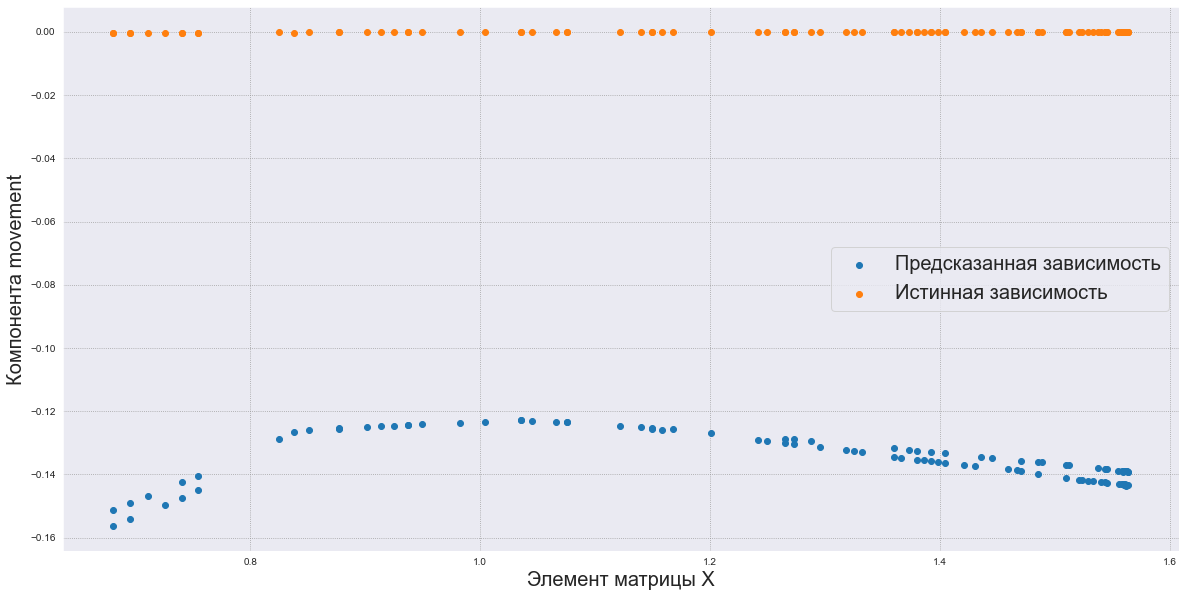

In [286]:
# if MODE != "movements":
plot_2d_result(
    x11_val,
    y_pred=Y_pred if len(train_data[0][1]) == 1 else [elem[0] for elem in Y_pred],
    y_true=Y_true if len(train_data[0][1]) == 1 else [elem[0] for elem in Y_true],
    figsize=(20, 10)
)

In [287]:
def plot_matrix(X, Y_pred, Y_true, figsize=(15, 15)):
    '''
    Function which plots matrix of dependencies: f_i(X_jj)
    '''
    k = len(Y_pred[0])
    fig, axes = plt.subplots(k, k, figsize=figsize)

    for i in range(k):  # цикл по компонентам силы
        y_pred = [elem[i] for elem in Y_pred]
        y_true = [elem[i] for elem in Y_true]
        for j in range(k):
            x = [elem.reshape(CFG.K, CFG.K)[j][j] for elem in X]
            axes[i][j].set_title(f'$f_{i}(X_{str(j)})$')
            axes[i][j].scatter(x, y_pred, label="Predicted", s=10)
            axes[i][j].scatter(x, y_true, label="True", s=10)
            axes[i][j].legend(loc="best")

if MODE != "movements":
    plot_matrix(
        X=val_X,
        Y_pred=Y_pred,
        Y_true=Y_true,

        figsize=(20, 20)
    )

Другой вариант:

Обучиться предсказывать элементарное перемещение по радиус вектору + вектору скорости (пока без скоростей)

Без скоростей - предсказание перемещения эквивалентно предсказанию силы:

$$
r(t+\Delta t) = r(t) v(t)\Delta t + \dfrac{1}{2}a(t)(\Delta t)^2
$$

$$
r(t+\Delta t) - r(t) = v(t)\Delta t + \dfrac{1}{2}a(t)(\Delta t)^2
$$

Ща два важных момента:
- эксопнента в формуле 
- пока матрица остается диагональной

- ITEM: TIMESTEP - это шаг интегратора; 

Что ща: надо обучить предсказывать элементарное перемещение - если пока не сработает на только координатах, то это норм, так как нужны еще скорости, но вообще скорости, координаты и силы - все это связано весьма явно: ускорение по предположению явная функция только координат, а остальнлое интегрированием

Короче: Имея координаты мы же можем предсказать силу, а из формулы верле это дает нам, что мы можем элементарное смещение за $\Delta$, зная скорости и координаты предсказать, поэтому текущая задача: на координатах обучиться предсказывать уже не силу, а элементарное смещение - так как наша задача интегрировать уравнения движения, еще раз скажу, что без скорости оно может не получиться и получение элементарного смещения вообще говоря может быть надо делать 2 моделями: одна по 

- Добавить в выпрямленную матрицу X в конец 3 числа: vx, vy, vz
- Для двух частиц "невращающихся" на матрице X из векторов V - которые по функции Леннарда Джонса на K = 3 на диагональной матрцие посчитаны

**Обучаем на перемещения**

In [288]:
target = torch.tensor(Y_true)
preds = torch.tensor(Y_pred)

mean_abs_percentage_error = MeanAbsolutePercentageError()
mean_abs_percentage_error(preds, target)

tensor(6712.8618)